<a href="https://colab.research.google.com/github/ngcheeyuan/Learner-s-Repo-for-Tensorflow/blob/main/malaria_infection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
ds , ds_info = tfds.load('malaria', 
                         as_supervised = True,
                         with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incomplete5129JZ/malaria-train.tfrecord


  0%|          | 0/27558 [00:00<?, ? examples/s]

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
ds_info

tfds.core.DatasetInfo(
    name='malaria',
    version=1.0.0,
    description='The Malaria dataset contains a total of 27,558 cell images
with equal instances of parasitized and uninfected cells from the thin blood 
smear slide images of segmented cells.',
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=27558,
    splits={
        'train': 27558,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward 
      improved malaria parasite detection in thin blood smear images},
      author={Rajaraman, Sivaramakrishnan and Antani, Sameer K and Poostchi, Mahdieh
      and Silamut, Kamolrat and Hossain, Md A and Maude, Richard J and Jaeger, 
      Stefan and Thoma, George R}

In [4]:
class_dict = {1:'uninfected',0:'infected'}

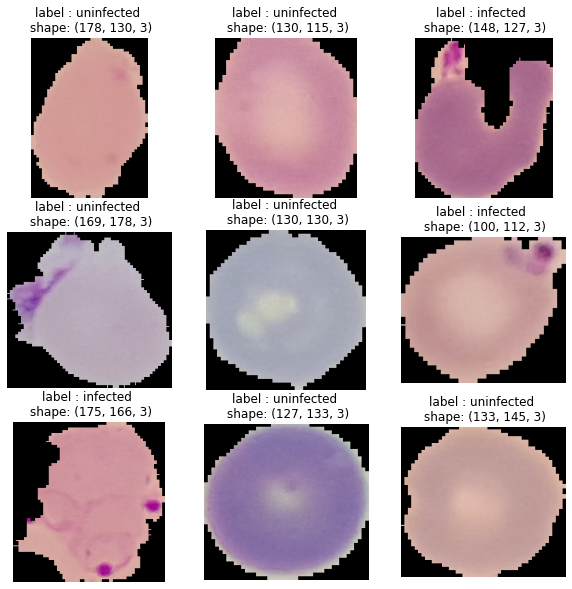

In [5]:
import random
random_index = random.randint(0,(len(ds['train'])-9))
samples = ds['train'].skip(random_index).take(9)
plt.figure(figsize = (10,10))

for index,(image,label) in enumerate(samples,1):
  plt.subplot(3,3,index)
  plt.imshow(image.numpy())
  plt.title(f'label : {class_dict[label.numpy()]} \n shape: {image.shape}')
  plt.axis(False)

In [6]:
dataset = ds['train'].take(len(ds['train']))

In [7]:
image_list = []
label_list = []

for image,label in dataset:
  image_list.append(image)
  label_list.append(label)

In [8]:
max_values = np.max([tf.reduce_max(image) for image in image_list])
min_values = np.min([tf.reduce_min(image) for image in image_list])
print('max value: ' , max_values)
print('min value: ' , min_values)

max value:  255
min value:  0


In [9]:
breath_list = [image.shape[0] for image in image_list]
height_list = [image.shape[1] for image in image_list]

In [10]:
shape_df = pd.DataFrame({'breath':breath_list,
                         'height':height_list})

In [11]:
shape_df.describe()

,breath,height
count,27558.000000,27558.000000
mean,132.983453,132.487154
std,20.619650,20.015949
min,40.000000,46.000000
25%,121.000000,121.000000
50%,130.000000,130.000000
75%,145.000000,142.000000
max,385.000000,394.000000


In [17]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
#inputs = layers.Input(shape=input_shape, name="input_layer")
inputs =tf.keras.layers.Input(shape = (224,224,3) , name = 'input_layer')

# Add in data augmentation Sequential model as a layer

# Give base_model inputs (after augmentation) and don't train it
x = base_model(inputs, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss= tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [22]:
def scale_resize_image(image, label):
    image = tf.image.resize(image, (224, 224)) # Resizing the image to 224x224 dimention
    return (image, label)

dataset = ds['train'].map(scale_resize_image)
batched_prefetched_dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [23]:
len(batched_prefetched_dataset)-603

259

In [24]:
train_data = batched_prefetched_dataset.take(603)
test_data = batched_prefetched_dataset.skip(603).take(259)

In [ ]:
model_1.fit(train_data,
            epochs = 5,
            validation_data = test_data)

Epoch 1/5
603/603 [==============================] - 161s 267ms/step - loss: 0.1873 - accuracy: 0.9318 - val_loss: 0.1542 - val_accuracy: 0.9458
Epoch 2/5
603/603 [==============================] - 159s 264ms/step - loss: 0.1414 - accuracy: 0.9502 - val_loss: 0.1408 - val_accuracy: 0.9509
Epoch 3/5
603/603 [==============================] - 159s 264ms/step - loss: 0.1318 - accuracy: 0.9529 - val_loss: 0.1345 - val_accuracy: 0.9528
Epoch 4/5
603/603 [==============================] - 159s 264ms/step - loss: 0.1264 - accuracy: 0.9550 - val_loss: 0.1306 - val_accuracy: 0.9542
Epoch 5/5
603/603 [==============================] - 160s 265ms/step - loss: 0.1227 - accuracy: 0.9565 - val_loss: 0.1279 - val_accuracy: 0.9555
